<a href="https://colab.research.google.com/github/picrin/2048/blob/master/Eagle2_benchmark2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import vcf
import collections
import subprocess
import matplotlib.pyplot as plt

# Benchmark of Eagle2

SNPs occur throughout human genome, including coding and non-coding regions. In this study we attempt to answer the following question:

Can modern phasing tools, supported with modern, large haplotype/genotype datasets (e.g. 1000 Genome project or the Haplotype Reference Consortium), assign a correct haplotype to SNPs situated in neighbouring genes?

We answer this question by studying two high-quality benchmark genomes, obtained as part of the Genome In A Bottle (GIAB) consortium. These datasets are:

1. the Ashkenazim Jewish trio (done)
2. the Asian trio (TODO).

A probabilistic answer to the question, i.e. "yes they can with probability 85%" would be satisfactory.

# Check the amount of space on the machine. At least 50 GB of space required



In [0]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   39G  302G  12% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1       365G   44G  322G  12% /opt/bin
shm             6.0G   12K  6.0G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware


## Download Eagle

In [0]:
!wget https://data.broadinstitute.org/alkesgroup/Eagle/downloads/Eagle_v2.4.1.tar.gz

--2019-07-14 19:20:28--  https://data.broadinstitute.org/alkesgroup/Eagle/downloads/Eagle_v2.4.1.tar.gz
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225286865 (215M) [application/x-gzip]
Saving to: ‘Eagle_v2.4.1.tar.gz’

Eagle_v2.4.1.tar.gz 100%[===================>] 214.85M  3.02MB/s    in 71s     

2019-07-14 19:21:40 (3.01 MB/s) - ‘Eagle_v2.4.1.tar.gz’ saved [225286865/225286865]



In [0]:
!tar -xvf Eagle_v2.4.1.tar.gz

Eagle_v2.4.1/
Eagle_v2.4.1/eagle
Eagle_v2.4.1/example/
Eagle_v2.4.1/example/target.vcf.gz
Eagle_v2.4.1/example/ref.bcf.csi
Eagle_v2.4.1/example/run_example.sh
Eagle_v2.4.1/example/example_ref.log
Eagle_v2.4.1/example/EUR_test.vcf.gz
Eagle_v2.4.1/example/example.log
Eagle_v2.4.1/example/target.vcf.gz.tbi
Eagle_v2.4.1/example/run_example_ref.sh
Eagle_v2.4.1/example/EUR_test.fam
Eagle_v2.4.1/example/phased.vcf.gz
Eagle_v2.4.1/example/target.phased.vcf.gz
Eagle_v2.4.1/example/run_example_vcf.sh
Eagle_v2.4.1/example/example_vcf.log
Eagle_v2.4.1/example/EUR_test.bim
Eagle_v2.4.1/example/phased.haps.gz
Eagle_v2.4.1/example/ref.bcf
Eagle_v2.4.1/example/phased.sample
Eagle_v2.4.1/example/EUR_test.bed
Eagle_v2.4.1/tables/
Eagle_v2.4.1/tables/genetic_map_hg18_withX.txt.gz
Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz
Eagle_v2.4.1/tables/genetic_map_hg19_withX.txt.gz
Eagle_v2.4.1/tables/genetic_map_1cMperMb.txt
Eagle_v2.4.1/tables/genetic_map_hg17_withX.txt.gz
Eagle_v2.4.1/src/
Eagle_v2.4.1/sr

In [0]:
!Eagle_v2.4.1/eagle --help

                      +-----------------------------+
                      |                             |
                      |   Eagle v2.4.1              |
                      |   November 18, 2018         |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2018 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

Eagle_v2.4.1/eagle \
    --help 


Options:

  --geneticMapFile arg             HapMap genetic map provided with download: 
                                   tables/genetic_map_hg##.txt.gz
  --outPrefix arg                  prefix for output files
  --numThreads arg (=1)            number of computational threads

Input options for phasing without a reference:
  --bfile arg                      prefix of PLINK .fam, .bim, .bed files
  --bfilegz arg                    prefix of PLINK .fam.gz, .

# Download the GIAB datasets

In [0]:
!wget ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG002_NA24385_son/latest/GRCh38/HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz

--2019-07-14 19:31:28--  ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG002_NA24385_son/latest/GRCh38/HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz
           => ‘HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz’
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.13
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.13|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /giab/ftp/release/AshkenazimTrio/HG002_NA24385_son/latest/GRCh38 ... done.
==> SIZE HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz ... 129195923
==> PASV ... done.    ==> RETR HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10Xsen

In [0]:
!mv HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz jewish_son.vcf.gz

In [0]:
!wget ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG003_NA24149_father/latest/GRCh38/HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz

--2019-07-14 19:56:52--  ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG003_NA24149_father/latest/GRCh38/HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz
           => ‘HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz’
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.11, 2607:f220:41e:250::12
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.11|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /giab/ftp/release/AshkenazimTrio/HG003_NA24149_father/latest/GRCh38 ... done.
==> SIZE HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz ... 110124812
==> PASV ... done.    ==> RETR HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.g

In [0]:
!mv HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz jewish_father.vcf.gz

In [0]:
!wget ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG004_NA24143_mother/latest/GRCh38/HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz

--2019-07-14 19:58:28--  ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG004_NA24143_mother/latest/GRCh38/HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz
           => ‘HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz’
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.13, 2607:f220:41e:250::11
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.13|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /giab/ftp/release/AshkenazimTrio/HG004_NA24143_mother/latest/GRCh38 ... done.
==> SIZE HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz ... 112000213
==> PASV ... done.    ==> RETR HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.g

In [0]:
!mv HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz jewish_mother.vcf.gz

In [0]:
cp jewish_son.vcf.gz jewish_son_copy.vcf.gz

In [0]:
cp jewish_father.vcf.gz jewish_father_copy.vcf.gz

In [0]:
cp jewish_mother.vcf.gz jewish_mother_copy.vcf.gz

In [0]:
!gunzip jewish_mother_copy.vcf.gz

In [0]:
!gunzip jewish_father_copy.vcf.gz

In [0]:
!gunzip jewish_son_copy.vcf.gz

In [0]:
!ls

Eagle_v2.4.1		jewish_father.vcf.gz	jewish_son_copy.vcf
Eagle_v2.4.1.tar.gz	jewish_mother_copy.vcf	jewish_son.vcf.gz
jewish_father_copy.vcf	jewish_mother.vcf.gz	sample_data


# Let's verify if the trio data was used correctly to phase the son genotype

In [0]:
!pip install pyvcf

  Stored in directory: /root/.cache/pip/wheels/81/91/41/3272543c0b9c61da9c525f24ee35bae6fe8f60d4858c66805d
Successfully built pyvcf


In [0]:
def output_SNP():
    alphabet = ["A", "T", "G", "C"]
    pos = [random.randint(0, len(alphabet) - 1) for i in range(2)]
    return [alphabet[i] for i in pos]

In [0]:
def create_genome(snp_length):
    genome = []
    for i in range(snp_length):
        genome.append(output_SNP())
    return genome

In [0]:
def cross_over(length):
    start = random.randint(0, 1)
    switch_over = random.randint(0, length - 1)
    selection = [start]
    for i in range(length - 1):
        if i < switch_over:
            selection.append(start)
        else:
            selection.append(int(not start))
    return selection

In [0]:
def apply_cross_over(cross_over, genome):
    return [genome[i][j] for i, j in zip(range(len(genome)), cross_over)]

In [0]:
def dephase(genome):
    dephased_genome = []
    for snp in genome:
        new_snp = [i for i in snp]
        random.shuffle(new_snp)
        dephased_genome.append(new_snp)
    return dephased_genome

In [0]:
def reproduce(genome1, genome2):
    co1 = cross_over(len(genome1))
    co2 = cross_over(len(genome2))
    haplo1 = apply_cross_over(co1, genome1)
    haplo2 = apply_cross_over(co2, genome2)
    return [list(k) for k in zip(haplo1, haplo2)]

In [0]:
length = 50

genome1 = create_genome(length)
genome2 = create_genome(length)
offspring = reproduce(genome1, genome2)

dephased_genome1 = dephase(genome1)
dephased_genome2 = dephase(genome2)
dephased_offspring = dephase(offspring)

In [0]:
def phase_offspring(genome1, genome2, offspring):
    possibilities = []
    phased_offspring = []
    for snp_o, snp_g1, snp_g2 in zip(offspring, genome1, genome2):
        snp_o = [i for i in snp_o]
        possibility = [[], []]
        for k in range(0, 2):
            if snp_o[k] in snp_g1:
                possibility[k].append(0)
            if snp_o[k] in snp_g2:
                possibility[k].append(1)
        possibilities.append(possibility)
        # The end statements protect us against a common failure mode which is false homozygosity,
        # i.e. calling a homozygous A/A as opposed to A/T due to low coverage on T
        if   (possibility[0] == [0] and 1 in possibility[1]) or (possibility[1] == [1] and 0 in possibility[0]):
            phased_offspring.append(snp_o + ["|"])
        elif (possibility[1] == [0] and 1 in possibility[0]) or (possibility[0] == [1] and 0 in possibility[1]):
            phased_offspring.append(snp_o[::-1] + ["-|"])
        else:
            phased_offspring.append(snp_o + ["?"])
    return phased_offspring

In [0]:
print(genome1)
print(genome2)
print(offspring)

[['G', 'C'], ['T', 'A'], ['A', 'C'], ['G', 'C'], ['G', 'G'], ['C', 'G'], ['T', 'G'], ['G', 'A'], ['C', 'G'], ['C', 'G'], ['C', 'G'], ['C', 'C'], ['C', 'G'], ['G', 'A'], ['C', 'G'], ['A', 'G'], ['A', 'C'], ['C', 'C'], ['C', 'C'], ['G', 'A'], ['A', 'A'], ['A', 'C'], ['T', 'A'], ['G', 'A'], ['G', 'T'], ['C', 'C'], ['T', 'A'], ['T', 'A'], ['C', 'T'], ['C', 'C'], ['T', 'A'], ['C', 'C'], ['C', 'C'], ['C', 'C'], ['C', 'G'], ['A', 'G'], ['G', 'G'], ['G', 'T'], ['T', 'T'], ['G', 'G'], ['G', 'C'], ['G', 'T'], ['A', 'C'], ['C', 'A'], ['T', 'C'], ['C', 'G'], ['A', 'C'], ['A', 'A'], ['T', 'A'], ['T', 'G']]
[['C', 'A'], ['C', 'G'], ['T', 'G'], ['C', 'A'], ['G', 'G'], ['T', 'C'], ['A', 'A'], ['T', 'G'], ['T', 'G'], ['C', 'T'], ['A', 'C'], ['C', 'G'], ['C', 'A'], ['C', 'T'], ['T', 'A'], ['T', 'G'], ['T', 'C'], ['G', 'A'], ['A', 'C'], ['G', 'C'], ['A', 'G'], ['T', 'T'], ['G', 'G'], ['T', 'G'], ['G', 'C'], ['G', 'G'], ['T', 'A'], ['A', 'T'], ['C', 'T'], ['G', 'A'], ['C', 'G'], ['A', 'T'], ['G', 'C'], ['

In [0]:
input_test1 = phase_offspring(genome1, genome2, offspring)
print(input_test1)

[['G', 'A', '|'], ['T', 'G', '|'], ['A', 'G', '|'], ['G', 'A', '|'], ['G', 'G', '?'], ['C', 'C', '?'], ['T', 'A', '|'], ['G', 'T', '|'], ['C', 'T', '|'], ['C', 'C', '?'], ['C', 'A', '|'], ['C', 'C', '?'], ['G', 'C', '|'], ['A', 'C', '|'], ['G', 'T', '|'], ['G', 'T', '|'], ['C', 'T', '|'], ['C', 'G', '|'], ['C', 'A', '|'], ['A', 'G', '|'], ['A', 'A', '?'], ['C', 'T', '|'], ['A', 'G', '|'], ['A', 'T', '|'], ['T', 'G', '|'], ['C', 'G', '|'], ['A', 'T', '?'], ['A', 'A', '?'], ['T', 'C', '?'], ['C', 'G', '|'], ['A', 'C', '|'], ['C', 'A', '|'], ['C', 'G', '|'], ['C', 'T', '|'], ['G', 'C', '|'], ['G', 'C', '|'], ['G', 'G', '?'], ['T', 'T', '?'], ['T', 'T', '?'], ['G', 'A', '|'], ['C', 'A', '|'], ['T', 'C', '|'], ['C', 'T', '|'], ['A', 'C', '|'], ['C', 'T', '|'], ['G', 'T', '|'], ['C', 'C', '?'], ['A', 'C', '|'], ['A', 'T', '?'], ['G', 'T', '|']]


In [0]:
h1, h2, _ = zip(*input_test1)

In [0]:
for snp, snps in zip(h1, genome1):
  assert snp in snps
for snp, snps in zip(h2, genome2):
  assert snp in snps

In [0]:
print(dephased_genome1)
print(dephased_genome2)
print(dephased_offspring)

[['C', 'T'], ['G', 'C'], ['C', 'G'], ['G', 'C'], ['A', 'G'], ['A', 'C']]
[['G', 'G'], ['A', 'A'], ['A', 'C'], ['C', 'G'], ['T', 'C'], ['A', 'T']]
[['T', 'G'], ['A', 'G'], ['G', 'A'], ['G', 'C'], ['T', 'G'], ['T', 'A']]


In [0]:
input_test2 = phase_offspring(dephased_genome1, dephased_genome2, dephased_offspring)
input_test2

[['T', 'G', '|'],
 ['G', 'A', '-|'],
 ['G', 'A', '|'],
 ['G', 'C', '?'],
 ['G', 'T', '-|'],
 ['A', 'T', '-|']]

In [0]:
assert [i[0] for i in input_test1 if i[2] != "?"] == [i[0] for i in input_test2 if i[2] != "?"] 

In [0]:
assert [i[1] for i in input_test1 if i[2] != "?"] == [i[1] for i in input_test2 if i[2] != "?"] 

In [0]:
for triplet1, triplet2 in zip(input_test1, input_test2):
    if triplet1[2] == "?" or triplet2[2] == "?":
        assert triplet1[2] == triplet2[2]

In [0]:
def load_vcf(filename, limit=-1, chrom_limit="", phased=False):
    genotype = {}
    for i, record in enumerate(vcf.Reader(filename=filename)):
        if record.CHROM == chrom_limit:
            break
        if i == limit:
            break
        snp = record.samples[0].gt_bases
        if record.samples[0].phased:
            a, b = snp.split("|")
        else:
            a, b = snp.split("/")
        if phased and record.samples[0].phased or not phased:
            genotype[(record.CHROM, record.POS)] = a, b
    return genotype

In [0]:
son = load_vcf("jewish_son_copy.vcf", chrom_limit="chr2")


In [0]:
mother = load_vcf("jewish_mother_copy.vcf", chrom_limit="chr2")


In [0]:
father = load_vcf("jewish_father_copy.vcf", chrom_limit="chr2")


In [0]:
son_genome = []
father_genome = []
mother_genome = []
shared_SNPs = sorted(list(set(son).intersection(set(mother)).intersection(set(father))))
for chr_coord in shared_SNPs:
    son_genome.append(son[chr_coord])
    father_genome.append(father[chr_coord])
    mother_genome.append(mother[chr_coord])

In [0]:
collections.Counter([i[0] for i in shared_SNPs])

Counter({'chr1': 170171})

In [0]:
chrom1_coords = [i[1] for i in shared_SNPs if i[0] == "chr1"]

In [0]:
length = chrom1_coords[-1] - chrom1_coords[0]

In [0]:
length

248097755

## Check average distance between SNPs

In [0]:
length/len(shared_SNPs)

1457.932050701941

In [0]:
phased_genome = phase_offspring(father_genome, mother_genome, son_genome)

In [0]:
phase_correctness = collections.Counter([i[-1] for i in phased_genome])

## Check fraction of incorrectly phased SNPs

In [0]:
phase_correctness["-|"]/len(phased_genome)

0.0024445998436866444

## Average distance per SNP suitable for trio phasing

In [0]:
length/collections.Counter([i[-1] for i in phased_genome])["|"]

7228.955565268066

This suggest that trio data allows phasing to within \~7 kilobases. An expectation would be that, due to the fact that one of the sequencing technologies used linked reads, which should allow for perfect phasing locally (up to [~50 kilobases](https://support.10xgenomics.com/genome-exome/sample-prep/doc/demonstrated-protocol-hmw-dna-extraction-from-whole-blood)), one would get a perfectly phased genome. However, from reading the GIAB paper it is unclear if linked reads were used in the phasing of the son's genotype: it appears that the pipeline used haplotype caller for the local phasing followed by pedigree phasing. The relevant sections are "Trio Mendelian analysis and phasing" as well "Phase transfer" in the [GIAB paper](https://www.nature.com/articles/s41587-019-0074-6.epdf?author_access_token=ewLdT4uP1jBiKAyJwAcYqdRgN0jAjWel9jnR3ZoTv0MC7r9js5eiMd8JOYV6BtmURFzOgi_efMREltCeCUbIMBRyA_gIv2G9qZgeMpo9LNcKpLG1_Cwxe2LAkjdrrr1Gy7vw-DLu8csTHvwSl5kdFA%3D%3D). In any case, one can conservatively assume that phasing to within 7kB is done correctly, or even more conservatively, one could restrict the analysis to correctly phased SNPs from the trio only.

In [0]:
phased_genome

[['A', 'A', '?'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['T', 'T', '?'],
 ['C', 'C', '?'],
 ['AT', 'AT', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['G', 'G', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['A', 'A', '?'],
 ['A', 'A', '?'],
 ['AGTTTT', 'AGTTTT', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['C', 'C', '?'],
 ['C', 'C', '?'],
 ['G', 'G', '?'],
 ['T', 'T', '?'],
 ['CCT', 'CCT', '?'],
 ['G', 'G', '?'],
 ['T', 'T', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['CAT', 'CAT', '?'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['G', 'G', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['G', 'G', '?'],
 ['A', '

In [0]:
len(shared_SNPs)

170171

In [0]:
shared_SNPs[0]

('chr1', 817186)

In [0]:
phased_genome[0]

['A', 'A', '?']

# Correctly phased SNPs from the trio

In [0]:
correctly_phased_SNPs = [coords for coords, snp in zip(shared_SNPs, phased_genome) if snp[2] == "|"]

In [0]:
correctly_phased_SNPs

[('chr1', 969377),
 ('chr1', 1129916),
 ('chr1', 1130879),
 ('chr1', 1130902),
 ('chr1', 1131008),
 ('chr1', 1131023),
 ('chr1', 1131566),
 ('chr1', 1131572),
 ('chr1', 1131573),
 ('chr1', 1132216),
 ('chr1', 1132294),
 ('chr1', 1132482),
 ('chr1', 1133289),
 ('chr1', 1134748),
 ('chr1', 1135061),
 ('chr1', 1135738),
 ('chr1', 1135812),
 ('chr1', 1137118),
 ('chr1', 1144906),
 ('chr1', 1152303),
 ('chr1', 1154630),
 ('chr1', 1157219),
 ('chr1', 1160003),
 ('chr1', 1161528),
 ('chr1', 1161720),
 ('chr1', 1161907),
 ('chr1', 1161955),
 ('chr1', 1162027),
 ('chr1', 1163334),
 ('chr1', 1163440),
 ('chr1', 1163962),
 ('chr1', 1164837),
 ('chr1', 1164939),
 ('chr1', 1165623),
 ('chr1', 1168162),
 ('chr1', 1168310),
 ('chr1', 1168578),
 ('chr1', 1866635),
 ('chr1', 1904424),
 ('chr1', 1943142),
 ('chr1', 1950848),
 ('chr1', 1951510),
 ('chr1', 1951521),
 ('chr1', 1951920),
 ('chr1', 1953616),
 ('chr1', 1954783),
 ('chr1', 1954946),
 ('chr1', 1955580),
 ('chr1', 1956930),
 ('chr1', 1957586),
 

# Scrambling the VCF file

In [0]:
def merge_record(old_record_str, new_record):
    s = old_record_str
    curr = 0
    peeled = []
    for elem in old_record_str.split():
        pos = s.find(elem)
        peeled.append(s[:pos])
        s = s[pos + len(elem):]
    to_collapse = []
    for i, j in zip(peeled, new_record):
        to_collapse.append(i)
        to_collapse.append(j)
    v = "".join(to_collapse) + s
    return v

In [0]:
def reverse_genotype(record_str):
    record = record_str.split()
    params = record[8].split(":")
    values = record[9].split(":")
    
    def reverse_GT(field):
        nonlocal record
        sep = "/"
        if sep not in field:
            sep = "|"
            if sep not in field:
                raise ValueError("GT issues with record: {}".format(record))

        a, b = field.split(sep)
        new_GT = "/".join([b, a])
        return new_GT, int(a), int(b)
    
    def reverse_field(field, a, b):
        elems = field.split(",")
        new_elems = [i for i in elems]
        new_elems[a] = elems[b]
        new_elems[b] = elems[a]
        return ",".join(new_elems)
    
    result = []
    for param, value in zip(params, values):
        if param in ["GT", "IGT"]:
            new_value, a, b = reverse_GT(value)
        elif param in ["ADALL", "AD"]:
            new_value = reverse_field(value, a, b)
        else:
            new_value = value
        result.append(new_value)
    new_record = [i for i in record]
    new_record[9] = ":".join(result)
    return merge_record(record_str, new_record)

In [0]:
test_record = "chr1	8303862	.	TCAAACAAACAAACAAACAAA	TCAAACAAACAAACAAA,T	50	PASS	platforms=2;platformnames=Illumina,10X;datasets=3;datasetnames=HiSeqPE300x,HiSeq250x250,10XChromium;callsets=5;callsetnames=HiSeqPE300xSentieon,HiSeq250x250Sentieon,HiSeqPE300xfreebayes,HiSeq250x250freebayes,10XSentieonhaplo;datasetsmissingcall=CGnormal,HiSeqMatePair,IonExome,SolidSE75bp;callable=CS_HiSeqPE300xSentieon_callable,CS_HiSeq250x250Sentieon_callable;filt=CS_HiSeqMatePairfreebayes_filt;difficultregion=AllRepeats_lt51bp_gt95identity_merged	GT:DP:ADALL:AD:GQ:IGT:IPS:PS	2/1:508:0,73,102:0,128,144:297:2|1:.:."

In [0]:
new_test_record = reverse_genotype(reverse_genotype(test_record))
assert "/".join(test_record.split("|")) == "/".join(new_test_record.split("|"))

In [0]:

with open("jewish_son_copy.vcf") as f:
    with open("reverse_jewish_son.vcf", "w") as g:
        for i, record in enumerate(f):
            if not record:
                g.write("")
            elif record and record[0] == "#":
                g.write(record)
            else:
                if random.randint(0, 1):
                    record = reverse_genotype(record)
                else:
                    record = reverse_genotype(reverse_genotype(record))
                g.write(record)

# Running eagle on the scrambled VCF file

In [0]:
print("hi")

hi


In [0]:
!rm ALL.chr*

In [0]:
link = "http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/release/20181203_biallelic_SNV/ALL.{chromosome}.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz{tabix}"

In [0]:
import subprocess
results = []
for chromosome in list(range(1, 23)) + ["X"]:
  full_chromosome = "chr{chromosome}".format(chromosome=chromosome)
  result = subprocess.Popen(["wget", link.format(chromosome=full_chromosome, tabix=".tbi")])
  results.append(result)
  result = subprocess.Popen(["wget", link.format(chromosome=full_chromosome, tabix="")])
  results.append(result)

In [0]:
for result in results:
  result.wait()

In [16]:
return_codes = [result.returncode for result in results]

AttributeError: ignored

In [0]:
assert not any(return_codes)

In [23]:
!apt-get install tabix

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tabix
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 326 kB of archives.
After this operation, 1,733 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tabix amd64 1.7-2 [326 kB]
Fetched 326 kB in 1s (560 kB/s)
Selecting previously unselected package tabix.
(Reading database ... 130963 files and directories currently installed.)
Preparing to unpack .../archives/tabix_1.7-2_amd64.deb ...
Unpacking tabix (1.7-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up tabix (1.7-2) ...


In [0]:
!bgzip reverse_jewish_son.vcf

In [0]:
!tabix reverse_jewish_son.vcf.gz

In [27]:
!Eagle_v2.4.1/eagle  --numThreads 15 --vcfTarget reverse_jewish_son.vcf.gz --vcfRef ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz --geneticMapFile=Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz --outPrefix reverse_son_jewish_phased

                      +-----------------------------+
                      |                             |
                      |   Eagle v2.4.1              |
                      |   November 18, 2018         |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2018 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

Eagle_v2.4.1/eagle \
    --numThreads 15 \
    --vcfTarget reverse_jewish_son.vcf.gz \
    --vcfRef ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz \
    --geneticMapFile=Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz \
    --outPrefix reverse_son_jewish_phased 

Setting number of threads to 15

Reference samples: Nref = 2548
Target samples: Ntarget = 1
SNPs to analyze: M = 234390 SNPs in both target and reference

SNPs ignored: 3361731 SNPs in target but not reference
       

# Checking how consistent is the assignment of SNPs within a hundred kilobases (just a bit over an average distance between two genes)

## Load scrambled and phased genotype

In [0]:
!gunzip reverse_son_jewish_phased.vcf.gz

In [34]:
phased_vcf = load_vcf("reverse_son_jewish_phased.vcf")

KeyboardInterrupt: ignored

## Load the benchmark genotype

In [0]:
positions = sorted(list(set(phased_vcf).intersection(set(son))))


## Prepare a dictionary, which records, per SNP location, if the assignment from Eagle2 was correct

In [0]:
phase_errors = {}
for position in positions:
    correct = son[position]
    phase_errors[position] = phased_vcf[position] == correct

In [0]:
phase_errors_items = list(phase_errors.items())

## Prepare a 100 kilobase window, and check consistency of SNP assignment in that window. Repeat `trials` times.

In [0]:
sparse_regions = 0

trials = 10000
window = 10**5

lengths = []
fraction = []
for i in range(trials):
    left = random.randint(phase_errors_items[0][0][1], phase_errors_items[-1][0][1])
    selected_window = [(i[1], j) for i, j in phase_errors_items if i[0] == "chr1" if i[1] < left + window and left < i[1]]
    if len(selected_window) < 20:
        sparse_regions += 1
        continue
    x, y = zip(*selected_window)
    counter = collections.Counter(y)
    correct, incorrect = counter[True], counter[False]
    f = max([correct, incorrect])/(correct+incorrect)
    lengths.append(len(x))
    fraction.append(f)

## Report the number of 100 kilobase windows, which have high sparsity of SNPs

In [42]:
sparse_regions

1769

## Average consistency of assignment per window

In [43]:
sum(fraction)/len(fraction)

0.8526703707757141

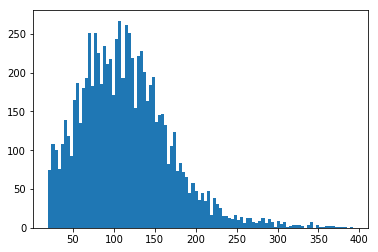

In [44]:
_ = plt.hist(lengths, bins=100)

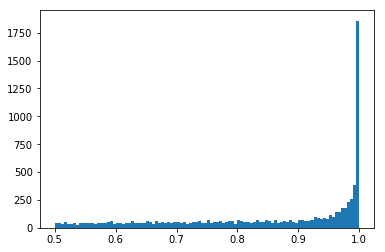

In [45]:
_ = plt.hist(fraction, bins=100)

In [0]:
## Plot phase assignment in a couple of windows for improved intuition

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

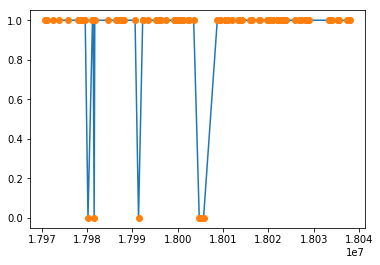

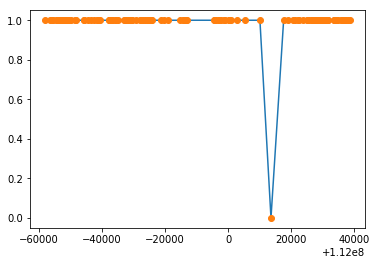

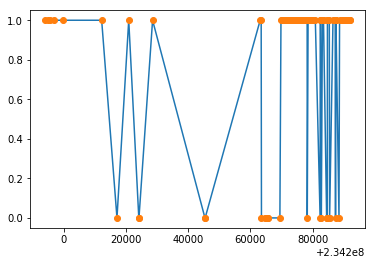

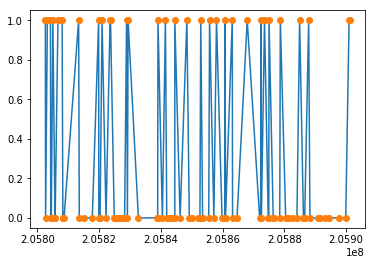

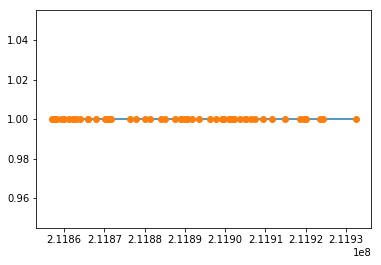

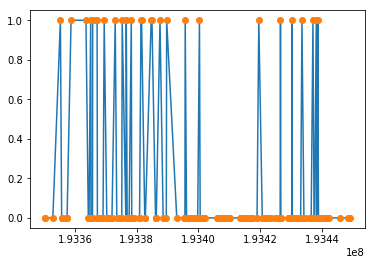

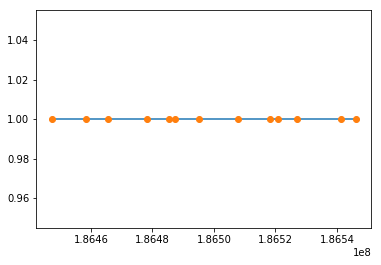

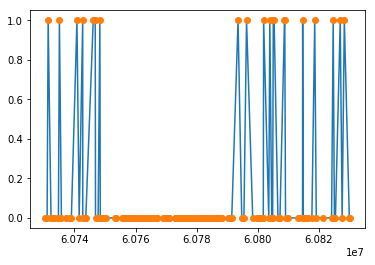

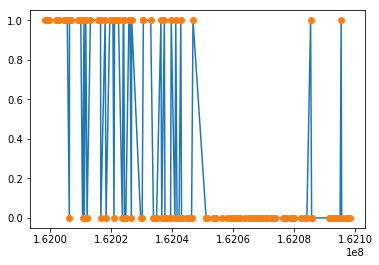

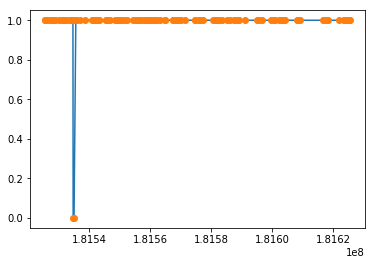

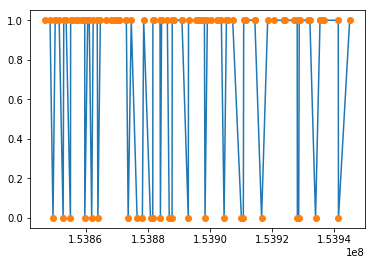

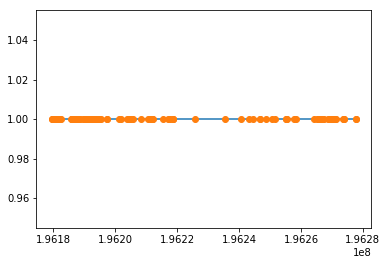

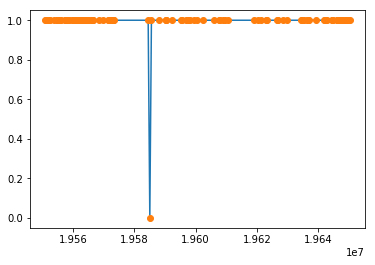

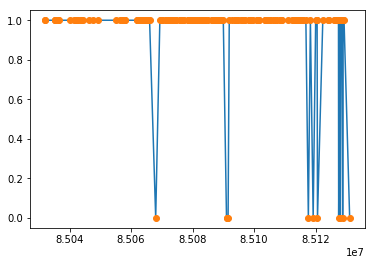

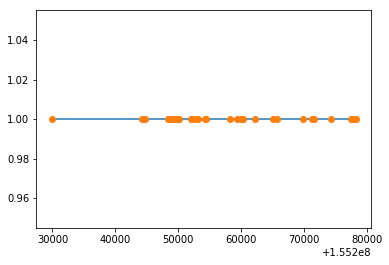

In [62]:
for i in range(20):
  left = random.randint(phase_errors_items[0][0][1], phase_errors_items[-1][0][1])
  window = 10**5
  selected_window = [(i[1], j) for i, j in phase_errors_items if i[0] == "chr1" if i[1] < left + window and left < i[1]]
  if len(selected_window) < 10:
      continue
  x, y = zip(*selected_window)
  plt.figure()
  plt.plot(x,y)
  plt.plot(x, y, "o")